# Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.max_rows', None)     
pd.set_option('display.float_format', '{:.4f}'.format)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

# Label Propagation Approach - Kmeans

In [2]:
player_stats = pd.read_csv('../data/player_stats.csv')
match_events = pd.read_csv('../data/match_event_base.csv')
shots_events = pd.read_csv('../data/shot_events.csv')
card_events = pd.read_csv('../data/card_events.csv')
match_stats = pd.read_csv('../data/norm_matches.csv')
rounds = pd.read_csv('../data/matches.csv')
players = pd.read_csv('../data/players.csv', encoding='utf-8')
seasons = pd.read_csv('../data/seasons.csv')

In [3]:
match_stats_full = match_stats.loc[match_stats['period'] == 'ALL']
match_stats_goals = match_stats_full.merge(rounds[['match_id', 'home_score', 'away_score']], on = 'match_id', how = 'left')
#match_stats_goals.head()

In [4]:
player_stats_name = player_stats.merge(players[['player_id', 'name']], on = 'player_id', how = 'left')
#player_stats_name.head()

In [5]:
match_stats_home = match_stats_goals[match_stats_goals['home_away'] == 'H'].copy()
match_stats_away = match_stats_goals[match_stats_goals['home_away'] == 'A'].copy()

# 2. Unir estadísticas de jugadores con las estadísticas de su PROPIO equipo (usando match_stats_goals)
df_player_with_own_team_stats = pd.merge(
    player_stats_name,
    match_stats_goals.add_suffix('_own_team'), 
    left_on=['match_id', 'team_id'],
    right_on=['match_id_own_team', 'team_id_own_team'],
    how='left'
)

df_player_with_own_team_stats = df_player_with_own_team_stats.drop(
     columns=['match_id_own_team', 'team_id_own_team'])

match_stats_home_opponent = match_stats_home.add_suffix('_opponent_team')
match_stats_away_opponent = match_stats_away.add_suffix('_opponent_team')


players_whose_team_was_home = df_player_with_own_team_stats[
    df_player_with_own_team_stats['home_away_own_team'] == 'H'
].copy()

players_whose_team_was_away = df_player_with_own_team_stats[
    df_player_with_own_team_stats['home_away_own_team'] == 'A'
].copy()


# 5. Unir jugadores con estadísticas de su equipo OPONENTE

merged_for_home_players_team = pd.merge(
    players_whose_team_was_home,
    match_stats_away_opponent,
    left_on=['match_id', 'opp_team_id_own_team'],
    right_on=['match_id_opponent_team', 'team_id_opponent_team'],
    how='left'
)

merged_for_away_players_team = pd.merge(
    players_whose_team_was_away,
    match_stats_home_opponent, 
    left_on=['match_id', 'opp_team_id_own_team'],
    right_on=['match_id_opponent_team', 'team_id_opponent_team'],
    how='left'
)
# 6. Concatenar los resultados
df_final = pd.concat([merged_for_home_players_team, merged_for_away_players_team], ignore_index=True)

df_final.head()


,player_match_stat_id,match_id,player_id,team_id,is_substitute,played_position,jersey_number,market_value_eur_at_match,sofascore_rating,minutes_played,touches,goals,assists,own_goals,passes_accurate,passes_total,passes_key,long_balls_accurate,long_balls_total,crosses_accurate,crosses_total,shots_total,shots_on_target,shots_off_target,shots_blocked_by_opponent,dribbles_successful,dribbles_attempts,possession_lost,dispossessed,duels_won,duels_lost,aerials_won,aerials_lost,ground_duels_won,ground_duels_total,tackles,interceptions,clearances,shots_blocked_by_player,dribbled_past,fouls_committed,fouls_suffered,saves,punches_made,high_claims,saves_inside_box,sweeper_keeper_successful,sweeper_keeper_total,goals_prevented,runs_out_successful,penalties_saved,penalty_committed,expected_goals,expected_assists,penalty_won,penalty_miss,big_chances_missed,errors_leading_to_shot,big_chances_created,errors_leading_to_goal,name,team_match_stat_id_own_team,opp_team_id_own_team,home_away_own_team,period_own_team,formation_own_team,average_team_rating_own_team,total_team_market_value_eur_own_team,possession_percentage_own_team,big_chances_own_team,total_shots_own_team,saves_own_team,corners_own_team,fouls_own_team,passes_successful_own_team,passes_total_own_team,passes_percentage_own_team,tackles_successful_own_team,tackles_total_own_team,tackles_won_percentage_own_team,free_kicks_own_team,yellow_cards_own_team,red_cards_own_team,shots_on_target_own_team,hit_woodwork_own_team,shots_off_target_own_team,blocked_shots_own_team,shots_inside_box_own_team,shots_outside_box_own_team,big_chances_missed_own_team,fouled_final_third_own_team,offsides_own_team,accurate_passes_percentage_own_team,throw_ins_own_team,final_third_entries_own_team,long_balls_successful_own_team,long_balls_total_own_team,long_balls_percentage_own_team,crosses_successful_own_team,crosses_total_own_team,crosses_percentage_own_team,duels_won_successful_own_team,duels_won_total_own_team,duels_won_percentage_own_team,dispossessed_own_team,ground_duels_successful_own_team,ground_duels_total_own_team,ground_duels_percentage_own_team,aerial_duels_successful_own_team,aerial_duels_total_own_team,aerial_duels_percentage_own_team,dribbles_successful_own_team,dribbles_total_own_team,dribbles_percentage_own_team,interceptions_own_team,clearances_own_team,goal_kicks_own_team,expected_goals_own_team,touches_in_penalty_area_own_team,passes_in_final_third_own_team,recoveries_own_team,errors_lead_to_shot_own_team,goals_prevented_own_team,big_saves_own_team,errors_lead_to_goal_own_team,penalty_saves_own_team,big_chances_scored_own_team,round_number_own_team,season_id_own_team,match_datetime_utc_own_team,home_score_own_team,away_score_own_team,team_match_stat_id_opponent_team,match_id_opponent_team,team_id_opponent_team,opp_team_id_opponent_team,home_away_opponent_team,period_opponent_team,formation_opponent_team,average_team_rating_opponent_team,total_team_market_value_eur_opponent_team,possession_percentage_opponent_team,big_chances_opponent_team,total_shots_opponent_team,saves_opponent_team,corners_opponent_team,fouls_opponent_team,passes_successful_opponent_team,passes_total_opponent_team,passes_percentage_opponent_team,tackles_successful_opponent_team,tackles_total_opponent_team,tackles_won_percentage_opponent_team,free_kicks_opponent_team,yellow_cards_opponent_team,red_cards_opponent_team,shots_on_target_opponent_team,hit_woodwork_opponent_team,shots_off_target_opponent_team,blocked_shots_opponent_team,shots_inside_box_opponent_team,shots_outside_box_opponent_team,big_chances_missed_opponent_team,fouled_final_third_opponent_team,offsides_opponent_team,accurate_passes_percentage_opponent_team,throw_ins_opponent_team,final_third_entries_opponent_team,long_balls_successful_opponent_team,long_balls_total_opponent_team,long_balls_percentage_opponent_team,crosses_successful_opponent_team,crosses_total_opponent_team,crosses_percentage_opponent_team,duels_won_successful_opponent_team,duels_won_total_opp

In [29]:

def safe_divide(numerator, denominator):
    num = pd.Series(numerator)
    den = pd.Series(denominator)
    return np.where(den.eq(0) | den.isnull() | num.isnull(), 0, num / den)

df_defensas = df_final.loc[(df_final['played_position'] == 'D') & (df_final['minutes_played'] >= 45)]

metricas_clave_centrales = [
    'aerials_lost', 'aerials_won', 'aerial_duels_successful_own_team',
    'big_chances_opponent_team', 'big_chances_scored_opponent_team', 'goals',
    'clearances', 'clearances_own_team', 'corners_opponent_team',
    'crosses_successful_opponent_team', 'crosses_total_opponent_team',
    'dribbled_past', 'duels_lost', 'duels_won', 'errors_lead_to_goal_own_team',
    'errors_lead_to_shot_own_team', 'errors_leading_to_goal', 'errors_leading_to_shot',
    'expected_goals_own_team', 'final_third_entries_opponent_team', 'fouls_committed',
    'fouls_opponent_team', 'ground_duels_total', 'ground_duels_won',
    'ground_duels_percentage_own_team', 'interceptions', 'interceptions_own_team',
    'long_balls_accurate', 'long_balls_total', 'minutes_played', 'offsides_opponent_team',
    'passes_accurate', 'passes_total', 'passes_total_own_team',
    'penalty_committed', 'possession_lost',
    'possession_percentage_own_team', 'recoveries_own_team',
    'shots_blocked_by_player', 'shots_on_target_opponent_team', 'shots_on_target_own_team',
    'sofascore_rating', 'tackles', 'tackles_won_percentage_own_team',
    'total_shots_opponent_team', 'total_shots_own_team', 'touches_in_penalty_area_opponent_team'
]

df_defensas['errors_leading_to_shot_vs_team_ratio'] = safe_divide(
    df_defensas['errors_leading_to_shot'], df_defensas['errors_lead_to_shot_own_team'])

df_defensas['errors_leading_to_goal_vs_team_ratio'] = safe_divide(
    df_defensas['errors_leading_to_goal'], df_defensas['errors_lead_to_goal_own_team'])

df_defensas['dribbles_total_vs_team_ratio'] = safe_divide(
    df_defensas['ground_duels_total'], df_defensas.get('dribbles_total_own_team', pd.Series(dtype=float)))

df_defensas['crosses_succ_vs_team_ratio'] = safe_divide(
    df_defensas['crosses_accurate'], df_defensas['crosses_successful_opponent_team'])

df_defensas['aerials_won_vs_team_ratio'] = safe_divide(
    df_defensas['aerials_won'], df_defensas['aerial_duels_successful_own_team'])

df_defensas['ground_duels_won_vs_team_ratio'] = safe_divide(
    df_defensas['ground_duels_won'], df_defensas['ground_duels_percentage_own_team'])

df_defensas['interceptions_vs_team_ratio'] = safe_divide(
    df_defensas['interceptions'], df_defensas['interceptions_own_team'])

df_defensas['clearances_vs_team_ratio'] = safe_divide(
    df_defensas['clearances'], df_defensas['clearances_own_team'])

df_defensas['tackles_vs_team_ratio'] = safe_divide(
    df_defensas['tackles'], df_defensas['tackles_won_percentage_own_team'])

df_defensas['passes_total_vs_team_ratio'] = safe_divide(
    df_defensas['passes_total'], df_defensas['passes_total_own_team'])

df_defensas['goles_recibidos_vs_ball_poss'] = np.where(
    df_defensas['home_away_own_team'] == 'H',
    safe_divide(df_defensas['away_score_opponent_team'], df_defensas['possession_percentage_opponent_team']),
    safe_divide(df_defensas['home_score_opponent_team'], df_defensas['possession_percentage_opponent_team'])
)

df_defensas['goles_recibidos_vs_big_chances_created'] = np.where(
    df_defensas['home_away_own_team'] == 'H',
    safe_divide(df_defensas['away_score_opponent_team'], df_defensas['big_chances_opponent_team']),
    safe_divide(df_defensas['home_score_opponent_team'], df_defensas['big_chances_opponent_team'])
)

df_defensas['possession_lost_vs_team_ratio'] = safe_divide(
    df_defensas['possession_lost'], df_defensas.get('dispossessed_own_team', pd.Series(dtype=float)))

df_defensas['fouls_committed_vs_team_ratio'] = safe_divide(
    df_defensas['fouls_committed'], df_defensas.get('fouls_own_team', pd.Series(dtype=float)))

df_defensas['long_balls_acc_vs_team_ratio'] = safe_divide(
    df_defensas['long_balls_accurate'], df_defensas.get('long_balls_percentage_own_team', pd.Series(dtype=float)) * 100)

df_defensas['shots_blocked_vs_team_ratio'] = safe_divide(
    df_defensas['shots_blocked_by_player'], df_defensas.get('blocked_shots_opponent_team', pd.Series(dtype=float)))

df_defensas['control_balon'] = safe_divide(
    df_defensas['possession_lost'], df_defensas['touches'])

nuevas = [
    'errors_leading_to_shot_vs_team_ratio', 'errors_leading_to_goal_vs_team_ratio',
    'dribbles_total_vs_team_ratio', 'crosses_succ_vs_team_ratio', 'aerials_won_vs_team_ratio',
    'ground_duels_won_vs_team_ratio', 'interceptions_vs_team_ratio', 'clearances_vs_team_ratio',
    'tackles_vs_team_ratio', 'passes_total_vs_team_ratio', 'goles_recibidos_vs_ball_poss',
    'goles_recibidos_vs_big_chances_created', 'possession_lost_vs_team_ratio', 'fouls_committed_vs_team_ratio',
    'long_balls_acc_vs_team_ratio', 'shots_blocked_vs_team_ratio', 'control_balon'
]


lista_vars_clave_completa = nuevas + metricas_clave_centrales
df_defensas = df_defensas.fillna(0)

#lista_vars_clave_completa
df_defensas_means = df_defensas.groupby(['player_id', 'name', 'team_id'])[lista_vars_clave_completa].agg('mean').reset_index()

flat_columns = []
for col in df_defensas_means.columns:
    if isinstance(col, tuple):
        if col[1] == 'mean':
            flat_columns.append(f"{col[0]}_m")
        elif col[1] == 'sum':
            flat_columns.append(f"{col[0]}_s")
        else:
            flat_columns.append(col[0])  
    else:
        flat_columns.append(col)  

df_defensas_means.columns = flat_columns

df_defensas_means = df_defensas_means.sort_values(by='sofascore_rating', ascending=False)

C:\Users\javie\AppData\Local\Temp\ipykernel_34184\965242295.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensas['errors_leading_to_shot_vs_team_ratio'] = safe_divide(
C:\Users\javie\AppData\Local\Temp\ipykernel_34184\965242295.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_defensas['errors_leading_to_goal_vs_team_ratio'] = safe_divide(
C:\Users\javie\AppData\Local\Temp\ipykernel_34184\965242295.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

In [30]:
df_defensas_means.head()

,player_id,name,team_id,errors_leading_to_shot_vs_team_ratio,errors_leading_to_goal_vs_team_ratio,dribbles_total_vs_team_ratio,crosses_succ_vs_team_ratio,aerials_won_vs_team_ratio,ground_duels_won_vs_team_ratio,interceptions_vs_team_ratio,clearances_vs_team_ratio,tackles_vs_team_ratio,passes_total_vs_team_ratio,goles_recibidos_vs_ball_poss,goles_recibidos_vs_big_chances_created,possession_lost_vs_team_ratio,fouls_committed_vs_team_ratio,long_balls_acc_vs_team_ratio,shots_blocked_vs_team_ratio,control_balon,aerials_lost,aerials_won,aerial_duels_successful_own_team,big_chances_opponent_team,big_chances_scored_opponent_team,goals,clearances,clearances_own_team,corners_opponent_team,crosses_successful_opponent_team,crosses_total_opponent_team,dribbled_past,duels_lost,duels_won,errors_lead_to_goal_own_team,errors_lead_to_shot_own_team,errors_leading_to_goal,errors_leading_to_shot,expected_goals_own_team,final_third_entries_opponent_team,fouls_committed,fouls_opponent_team,ground_duels_total,ground_duels_won,ground_duels_percentage_own_team,interceptions,interceptions_own_team,long_balls_accurate,long_balls_total,minutes_played,offsides_opponent_team,passes_accurate,passes_total,passes_total_own_team,penalty_committed,possession_lost,possession_percentage_own_team,recoveries_own_team,shots_blocked_by_player,shots_on_target_opponent_team,shots_on_target_own_team,sofascore_rating,tackles,tackles_won_percentage_own_team,total_shots_opponent_team,total_shots_own_team,touches_in_penalty_area_opponent_team
1048,1400106,Yankuba Minteh,30,0.0000,0.0000,0.2857,2.0000,0.1538,20.0000,0.0769,0.0312,9.0909,0.0367,0.0000,0.0000,0.7500,0.0833,0.0000,0.0000,0.2571,3.0000,2.0000,13.0000,1.0000,0.0000,2.0000,1.0000,32.0000,9.0000,1.0000,18.0000,4.0000,10.0000,12.0000,0.0000,0.0000,0.0000,0.0000,1.4200,1.0000,1.0000,15.0000,4.0000,10.0000,0.5000,1.0000,13.0000,0.0000,0.0000,89.0000,3.0000,8.0000,12.0000,327.0000,0.0000,9.0000,0.3100,36.0000,0.0000,0.0000,5.0000,9.5000,5.0000,0.5500,8.0000,13.0000,26.0000
626,831808,Federico Valverde,2829,0.0000,0.0000,0.0723,0.2917,0.0778,0.8333,0.2583,0.1705,1.1001,0.1038,0.5435,0.0833,1.4964,0.1571,0.0658,0.0000,0.1087,0.7500,1.0000,10.2500,1.0000,0.2500,0.5000,3.2500,17.5000,3.0000,2.2500,14.0000,0.2500,2.5000,2.2500,0.0000,0.0000,0.0000,0.0000,1.1975,1.0000,1.2500,15.0000,1.2500,0.5000,0.5225,2.0000,8.7500,4.2500,5.7500,90.0000,1.5000,54.0000,59.0000,566.7500,0.0000,8.2500,0.6100,36.2500,0.0000,1.7500,6.0000,8.0500,0.5000,0.6115,6.0000,17.5000,11.0000
872,966940,José Gragera,2814,0.0000,0.0000,0.0000,0.0000,0.1250,8.5106,0.3333,0.4091,6.0000,0.1516,0.0000,0.0000,0.8571,0.0000,0.0652,0.3333,0.0750,1.0000,2.0000,16.0000,2.0000,0.0000,0.0000,9.0000,22.0000,10.0000,10.0000,30.0000,0.0000,1.0000,6.0000,0.0000,0.0000,0.0000,0.0000,1.3000,0.0000,0.0000,11.0000,0.0000,4.0000,0.4700,1.0000,3.0000,3.0000,3.0000,90.0000,5.0000,56.0000,62.0000,409.0000,0.0000,6.0000,0.5400,0.0000,2.0000,5.0000,4.0000,7.9000,3.0000,0.5000,19.0000,11.0000,0.0000
636,839309,Paul Akouokou,2816,0.0000,0.0000,0.0000,0.0000,0.1333,3.8462,0.1250,0.2778,4.0000,0.0636,0.0000,0.0000,0.5714,0.0000,0.0267,0.3333,0.1000,1.0000,2.0000,15.0000,1.0000,0.0000,0.0000,10.0000,36.0000,13.0000,7.0000,40.0000,0.0000,1.0000,4.0000,0.0000,0.0000,0.0000,0.0000,1.2100,2.0000,0.0000,13.0000,0.0000,2.0000,0.5200,2.0000,16.0000,1.0000,3.0000,90.0000,2.0000,18.0000,21.0000,330.0000,0.0000,4.0000,0.3700,0.0000,2.0000,6.0000,2.0000,7.9000,2.0000,0.5000,21.0000,12.0000,0.0000
341,259339,Rubén Alcaraz,2831,0.0000,0.0000,0.0833,0.0000,0.0000,0.0000,0.0000,0.1000,11.3747,0.1457,5.2632,2.0000,0.5714,0.0000,0.1455,0.5000,0.0449,0.0000,0.0000,12.0000,1.0000,1.0000,0.0000,1.0000,10.0000,5.0000,1.0000,12.0000,0.0000,0.0000,9.0000,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000,0.0000,19.0000,1.0000,0.0000,0.5900,0.0000,3.0000,8.0000,11.0000,90.0000,1.0000,68.0000,72.0000,494.0000,0.0000,4.0000,0.6200,0.0000,1.0000,3.0000,2.0000,7.7000,7.0000,0.6154,9.0000,13.0000,0.0000


In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


X_players = df_defensas_means[lista_vars_clave_completa]
scaler = StandardScaler()
X_players_scaled = pd.DataFrame(scaler.fit_transform(X_players), index = X_players.index, columns = X_players.columns)

X_players_scaled = pd.concat([df_defensas_means[['player_id', 'name']], X_players_scaled], axis=1)
X_players_scaled.head()

,player_id,name,errors_leading_to_shot_vs_team_ratio,errors_leading_to_goal_vs_team_ratio,dribbles_total_vs_team_ratio,crosses_succ_vs_team_ratio,aerials_won_vs_team_ratio,ground_duels_won_vs_team_ratio,interceptions_vs_team_ratio,clearances_vs_team_ratio,tackles_vs_team_ratio,passes_total_vs_team_ratio,goles_recibidos_vs_ball_poss,goles_recibidos_vs_big_chances_created,possession_lost_vs_team_ratio,fouls_committed_vs_team_ratio,long_balls_acc_vs_team_ratio,shots_blocked_vs_team_ratio,control_balon,aerials_lost,aerials_won,aerial_duels_successful_own_team,big_chances_opponent_team,big_chances_scored_opponent_team,goals,clearances,clearances_own_team,corners_opponent_team,crosses_successful_opponent_team,crosses_total_opponent_team,dribbled_past,duels_lost,duels_won,errors_lead_to_goal_own_team,errors_lead_to_shot_own_team,errors_leading_to_goal,errors_leading_to_shot,expected_goals_own_team,final_third_entries_opponent_team,fouls_committed,fouls_opponent_team,ground_duels_total,ground_duels_won,ground_duels_percentage_own_team,interceptions,interceptions_own_team,long_balls_accurate,long_balls_total,minutes_played,offsides_opponent_team,passes_accurate,passes_total,passes_total_own_team,penalty_committed,possession_lost,possession_percentage_own_team,recoveries_own_team,shots_blocked_by_player,shots_on_target_opponent_team,shots_on_target_own_team,sofascore_rating,tackles,tackles_won_percentage_own_team,total_shots_opponent_team,total_shots_own_team,touches_in_penalty_area_opponent_team
1048,1400106,Yankuba Minteh,-0.2352,-0.1537,4.4552,9.5946,0.8782,6.9867,-0.6941,-1.6407,3.9233,-2.5011,-2.2753,-2.0663,-1.1124,0.0803,-1.6318,-1.2184,0.9651,2.7725,0.5446,-0.4196,-1.2847,-1.6251,20.5710,-1.1846,2.5146,2.4782,-2.5344,-0.0924,6.6637,5.6175,5.3564,-0.3327,-0.4357,-0.2535,-0.4023,0.9909,-1.6579,0.1361,1.3470,3.7269,6.9282,0.0273,-0.1074,1.9785,-1.5837,-1.9615,0.7517,1.1903,-1.7996,-1.9617,-1.1147,-0.3217,-0.3857,-2.0985,0.6338,-1.2041,-3.2106,0.7342,9.3483,3.8475,-0.6906,-1.6100,0.4810,2.0192
626,831808,Federico Valverde,-0.2352,-0.1537,0.3997,0.9462,-0.3445,-1.1308,2.4593,0.3669,-1.1530,0.4212,-1.8860,-1.7928,0.0525,1.7501,0.7449,-1.2184,-1.1857,-0.6406,-0.4828,-1.1191,-1.2847,-1.2016,4.8822,0.2917,-0.3962,-1.3638,-1.5975,-1.0488,-0.7650,-0.7548,-1.3392,-0.3327,-0.4357,-0.2535,-0.4023,0.6538,-1.6579,0.6343,1.3470,0.5110,-1.0510,0.7797,1.6462,-0.1109,1.6625,0.3721,0.8594,-0.4488,1.3329,1.1611,1.4150,-0.3217,-0.5854,1.4507,0.6451,-1.2041,-1.9894,1.4903,4.3073,-1.2953,0.3673,-2.2624,2.0759,0.5095
872,966940,José Gragera,-0.2352,-0.1537,-0.9732,-0.5304,0.4145,2.1207,3.7630,3.8085,1.9597,2.5031,-2.2753,-2.0663,-0.9452,-1.8050,0.7237,1.8577,-1.6736,-0.2614,0.5446,0.3434,-0.2904,-1.6251,-0.3474,4.0648,0.5072,3.1185,4.2112,2.7769,-1.2602,-2.0292,1.2361,-0.3327,-0.4357,-0.2535,-0.4023,0.8091,-2.9317,-1.8569,-0.4118,-0.9508,1.8887,-0.9759,-0.1074,-2.9377,0.7077,-0.7440,0.8594,3.3756,1.4691,1.3605,-0.2495,-0.3217,-1.1842,0.6226,-0.9862,3.8893,0.2786,-0.0218,3.7858,1.5618,-1.5507,1.9782,-0.2278,-0.5976
636,839309,Paul Akouokou,-0.2352,-0.1537,-0.9732,-0.5304,0.5485,0.1452,0.1416,1.9147,0.6892,-1.3277,-2.2753,-2.0663,-1.3911,-1.8050,-0.6687,1.8577,-1.3114,-0.2614,0.5446,0.0891,-1.2847,-1.6251,-0.3474,4.7209,3.3176,5.0395,1.9627,5.1679,-1.2602,-2.0292,-0.1374,-0.3327,-0.4357,-0.2535,-0.4023,0.6728,-0.3841,-1.8569,0.4676,-0.9508,0.2089,0.6961,1.6462,3.4533,-0.8199,-0.7440,0.8594,0.0976,-1.1186,-1.3637,-1.0831,-0.3217,-1.7165,-1.3887,-0.9862,3.8893,0.9764,-1.5340,3.7858,0.4190,-1.5507,2.6306,0.1266,-0.5976
341,259339,Rubén Alcaraz,-0.2352,-0.1537,0.6101,-0.5304,-1.5947,-1.4837,-2.0313,-0.6492,5.3741,2.2487,1.4940,4.4977,-1.3911,-1.8050,3.6216,3.3958,-2.1090,-1.7783,-1.5101,-0.6740,-1.2847,0.0688,-0.3474,-1.1846,-1.9018,-0.0832,-2.5344,-1.5270,-1.2602,-2.8789,3.2962,-0.3327,-0.4357,-0.2535,-0.4023,-1.1602,0.8896,-1.8569,3.1057,0.2186,-1.4710,3.0369,-1.8610,-2.9377,4.5268,2.5028,0.8594,-0.9951,2.2863,2.0249,0.6474,-0.3217,-1.7165,1.5690,-0.9862,1.3

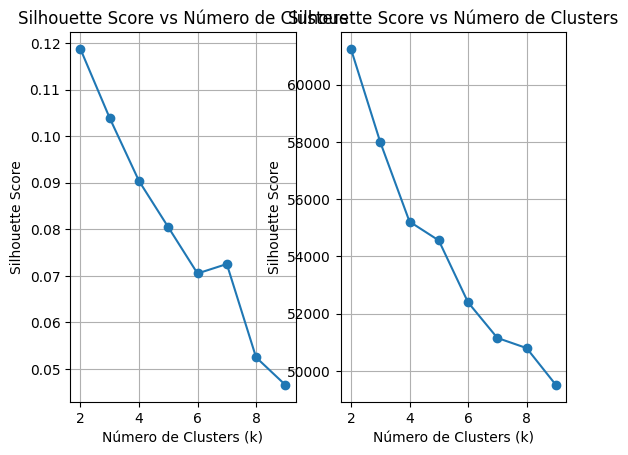

In [35]:
sil_score = {}
inertia_score = {}
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=2025, n_init='auto') 
    labels = kmeans.fit_predict(X_players_scaled[lista_vars_clave_completa])  
    sil_score[k] = silhouette_score(X_players_scaled[lista_vars_clave_completa], labels)
    inertia_score[k] = kmeans.inertia_
plt.subplot(1,2,1)
plt.plot(list(sil_score.keys()), list(sil_score.values()), marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Número de Clusters")
plt.grid(True)


plt.subplot(1,2,2)
plt.plot(list(inertia_score.keys()), list(inertia_score.values()), marker='o')
plt.xlabel("Número de Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs Número de Clusters")
plt.grid(True)

plt.show()

In [41]:
kmeans = KMeans(n_clusters=2, random_state=2025, n_init='auto') 
labels = kmeans.fit_predict(X_players_scaled[lista_vars_clave_completa])
X_players_scaled['position'] = labels

X_players_scaled['position'].value_counts()

X_players_scaled[['name', 'position']].head(50)


,name,position
1048,Yankuba Minteh,1
626,Federico Valverde,0
872,José Gragera,0
636,Paul Akouokou,0
341,Rubén Alcaraz,0
917,Kike Hermoso,0
371,Wes Burns,0
1004,Sergio Arribas,1
846,Mats Wieffer,1
1020,Tyler Fredricson,0


In [42]:
centrales = [
    "Rúben Dias",           # Manchester City (Premier League)
    "Virgil van Dijk",      # Liverpool (Premier League)
    "William Saliba",       # Arsenal (Premier League)
    "Gabriel Magalhães",    # Arsenal (Premier League)
    "Antonio Rüdiger",      # Chelsea (Premier League) / Real Madrid (La Liga)
    "Éder Militão",         # Real Madrid (La Liga)
    "Ronald Araújo",        # Barcelona (La Liga)
    "Jules Koundé",         # Sevilla / Barcelona (La Liga) - (aunque a veces lateral, es central top)
    "Lisandro Martínez",    # Manchester United (Premier League)
    "Cristian Romero",      # Tottenham Hotspur (Premier League)
    "Sven Botman",          # Newcastle United (Premier League)
    "Pau Torres",           # Villarreal (La Liga) / Aston Villa (Premier League)
    "David Alaba",          # Real Madrid (La Liga) - (aunque versátil, mucho de central en Madrid)
    "Ibrahima Konaté",      # Liverpool (Premier League)
    "Manuel Akanji",        # Manchester City (Premier League)
    "John Stones",          # Manchester City (Premier League)
    "José María Giménez",   # Atlético Madrid (La Liga)
    "Stefan Savić",         # Atlético Madrid (La Liga)
    "Andreas Christensen",  # Chelsea (Premier League) / Barcelona (La Liga)
    "Robin Le Normand",     # Real Sociedad (La Liga)
    "Yeray Álvarez",        # Athletic Bilbao (La Liga)
    "David García",         # Osasuna (La Liga)
    "Nayef Aguerd",         # West Ham United (Premier League)
    "Kurt Zouma",           # Chelsea / West Ham United (Premier League)
    "Ezri Konsa"            # Aston Villa (Premier League)
]
#=====================================================================================
laterales = [
    "Kyle Walker",            # Manchester City (Premier League) - LD
    "João Cancelo",           # Man City (Premier League) / Barcelona (La Liga) - LD/LI
    "Andrew Robertson",       # Liverpool (Premier League) - LI
    "Trent Alexander-Arnold", # Liverpool (Premier League) - LD
    "Reece James",            # Chelsea (Premier League) - LD
    "Ben Chilwell",           # Chelsea (Premier League) - LI
    "Kieran Trippier",        # Atlético Madrid (La Liga) / Newcastle (Premier League) - LD
    "Luke Shaw",              # Manchester United (Premier League) - LI
    "Dani Carvajal",          # Real Madrid (La Liga) - LD
    "Ferland Mendy",          # Real Madrid (La Liga) - LI
    "Alejandro Balde",        # Barcelona (La Liga) - LI
    "Nahuel Molina",          # Atlético Madrid (La Liga) - LD
    "José Gayà",              # Valencia (La Liga) - LI
    "Marcos Acuña",           # Sevilla (La Liga) - LI
    "Jesús Navas",            # Sevilla (La Liga) - LD
    "Pedro Porro",            # Tottenham Hotspur (Premier League) - LD
    "Jordi Alba",         # Tottenham Hotspur (Premier League) - LI
    "Oleksandr Zinchenko",    # Man City / Arsenal (Premier League) - LI
    "Ben White",              # Arsenal (Premier League) - LD (aunque fue central, reconvertido)
    "Pervis Estupiñán",       # Villarreal (La Liga) / Brighton (Premier League) - LI
    "Matty Cash",             # Aston Villa (Premier League) - LD
    "Alphonso Pedraza",       # Villarreal (La Liga) - LI
    "Marc Cucurella",         # Getafe (La Liga) / Brighton / Chelsea (Premier League) - LI
    "Diogo Dalot",            # Manchester United (Premier League) - LD/LI
    "Tyrick Mitchell"         # Crystal Palace (Premier League) - LI
]
print(len(laterales))

25


In [54]:
posiciones_prueba = X_players_scaled.loc[X_players_scaled['name'].isin(laterales)]
posiciones_prueba[['position', 'name']].head(50)

,position,name
109,1,Kieran Trippier
525,1,Trent Alexander-Arnold
224,1,João Cancelo
770,1,Pedro Porro
223,1,João Cancelo
46,1,Jordi Alba
110,1,Kieran Trippier
736,1,Reece James
345,1,Andrew Robertson
519,1,Marc Cucurella


In [ ]:
jugadores_interes = df_defensas[df_defensas['name'].isin(centrales)]
df_5_partidos_por_defensa_central = (jugadores_interes.groupby('name', group_keys=False)
                            .apply(lambda x: x.sample(n = min(5, len(x)), random_state = 2024)).reset_index(drop=True))
df_5_partidos_por_defensa_central['cluster_positions'] = 'CB'
#df_5_partidos_por_defensa_central.head(10)

jugadores_interes_lateral = df_defensas[df_defensas['name'].isin(laterales)]
df_5_partidos_por_lateral = (jugadores_interes_lateral.groupby('name', group_keys=False)
                            .apply(lambda x: x.sample(n = min(5, len(x)), random_state = 2024)).reset_index(drop=True))

df_5_partidos_por_lateral['cluster_positions'] = 'LB'
#df_5_partidos_por_lateral.head(15)

df_labeled = pd.concat([df_5_partidos_por_lateral, df_5_partidos_por_defensa_central], ignore_index=True)
df_labeled.shape

In [ ]:
df_defensas_cluster = df_defensas.copy()
df_defensas_cluster = df_defensas_cluster.merge(
    df_labeled[['match_id', 'cluster_positions', 'name']],
    on=['match_id', 'name'],
    how='left'
)
df_defensas_cluster['cluster_positions'] = df_defensas_cluster['cluster_positions'].fillna('-1')
df_defensas_cluster['cluster_positions'] = df_defensas_cluster['cluster_positions'].map({'-1':-1, 'CB': 0, 'LB': 1})
df_defensas_cluster['cluster_positions'].value_counts()

info_vars_df = df_defensas_cluster.drop(['match_id', 'name', 'player_id', 'played_position', 'team_id'], axis = 1)
X_train_df = df_defensas

In [ ]:
info_vars_df = df_defensas_cluster.drop(['match_id', 'name', 'player_id', 'played_position', 'team_id'], axis = 1)
y_train = 
X_train_df = df_defensas